<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Setup" data-toc-modified-id="Setup-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Setup</a></span></li><li><span><a href="#Loading-data" data-toc-modified-id="Loading-data-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Loading data</a></span></li><li><span><a href="#Correlation-Analysis" data-toc-modified-id="Correlation-Analysis-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Correlation Analysis</a></span><ul class="toc-item"><li><span><a href="#Correlation-Matrix" data-toc-modified-id="Correlation-Matrix-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Correlation Matrix</a></span></li><li><span><a href="#Categorical-Variables-Correlation" data-toc-modified-id="Categorical-Variables-Correlation-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Categorical Variables Correlation</a></span></li><li><span><a href="#Location" data-toc-modified-id="Location-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Location</a></span></li><li><span><a href="#Confounding-Variables" data-toc-modified-id="Confounding-Variables-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Confounding Variables</a></span></li></ul></li><li><span><a href="#Paired-Test-Design" data-toc-modified-id="Paired-Test-Design-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Paired Test Design</a></span><ul class="toc-item"><li><span><a href="#Subjective-Way" data-toc-modified-id="Subjective-Way-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Subjective Way</a></span></li><li><span><a href="#Using-KD-Tree-to-find-paired-tests-systematically" data-toc-modified-id="Using-KD-Tree-to-find-paired-tests-systematically-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Using KD-Tree to find paired tests systematically</a></span></li></ul></li></ul></div>

# Setup

In [15]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from shutil import copyfileobj
from six.moves import urllib

%matplotlib inline

def filepath(data_url, file_name):
    data_path = os.path.join('Data')
    if not os.path.exists(data_path):
        os.makedirs(data_path)
    data_save_path = os.path.join(data_path, file_name)
    
    if not os.path.exists(data_save_path):
        data_local = urllib.request.urlopen(data_url)
        with open(data_save_path, "wb") as csv_file:
            copyfileobj(data_local, csv_file)

        
    return data_save_path

data_url = 'http://video.udacity-data.com.s3.amazonaws.com/topher/2017/February/58926735_newproductcontroldata/newproductcontroldata.csv'
file_name = 'newproductcontroldata.csv'

data = filepath(data_url, file_name)

treatment_url = 'http://video.udacity-data.com.s3.amazonaws.com/topher/2016/September/57d439f7_grapeproducttreatmentstores/grapeproducttreatmentstores.csv'
treatment_file = 'grapeproducttreatmentstores.csv'
treatment = filepath(treatment_url, treatment_file)

# Loading data

In [2]:
df = pd.read_csv(data)
print(df.shape)
df.head()

(7008, 7)


,Store ID,City,State,Zip Code,Category Sales,Product Count,Size
0,1,ALABASTER,AL,35007,18.88,1,Large
1,2,BIRMINGHAM,AL,35209,44125.66,6,Large
2,3,DECATUR,AL,35601,46627.92,5,Large
3,4,HUNTSVILLE,AL,35806,26658.48,6,Large
4,5,MOBILE,AL,36606,1863.60,3,Large


# Correlation Analysis

## Correlation Matrix

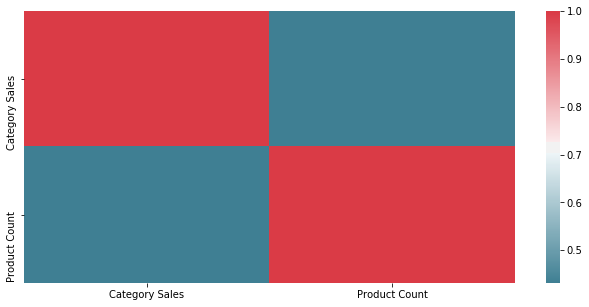

In [3]:
import seaborn as sns

corr_matrix = df[['Category Sales','Product Count']].corr()


# setting up color map
cmap = sns.diverging_palette(220, 10, as_cmap = True)

plt.figure(figsize = (11,5))
sns.heatmap(corr_matrix, cmap = cmap)

We can see that Category Sales are quite positively correlated to Product Count

In [4]:
corr_matrix

,Category Sales,Product Count
Category Sales,1.000000,0.431881
Product Count,0.431881,1.000000


With a 0.43 Correlation Coefficient

## Categorical Variables Correlation

Ignore Future Warning:

In [5]:
import warnings
warnings.filterwarnings('ignore', category = FutureWarning)

We used a Violin Plot with `Seaborn` here because there are a lot of outliers

<Figure size 792x360 with 0 Axes>

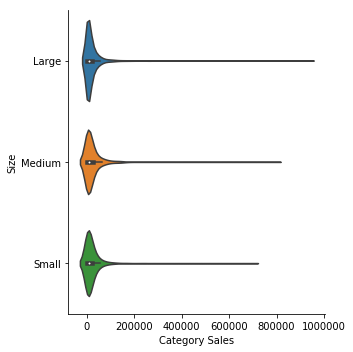

In [6]:
plt.figure(figsize = (11,5))
sns.catplot(x = 'Category Sales', y= 'Size' , data = df, kind = 'violin')

In this case, the Store Size seems not to have a very good correlation to Sales

## Location

We can use `groupby` then `agg` and `nunique()` method to aggregate the data to see how many distinct Store ID there are by combination of City, State and Zip Code.

In [7]:
df.groupby(['City','State','Zip Code']).agg(
    {'Store ID': lambda x: x.nunique()}).sort_values(
    by = 'Store ID', ascending = False).head()

,,,Store ID
City,State,Zip Code,
Bentonville,AR,72712,11
Chino,CA,91710,7
Tulsa,OK,74133,6
El Paso,TX,79936,6
San Francisco,CA,94103,6


Seems like at Zip-5 level; most locations have only 1 store (with total of 7008 stores); if we go higher at City Level, there are more stores at that level for sure; but we are only getting about 2 stores per city -- that's not good for comparison, so we should go one level further

In [8]:
df.groupby(['City','State']).agg(
    {'Store ID': lambda x: x.nunique()}).sort_values(
    by = 'Store ID', ascending = False).mean()

Store ID    2.06239
dtype: float64

Here at State Level, this is probably good for comparison within states -- we would __assume stores within the same state performs more alike than stores perform in different state__. <br>
e.g. A store in Alaska would be more similar to another store in Alaska than compared to a store in New York

In [9]:
df_state = df.groupby(['State']).agg(
    {'Store ID': lambda x: x.nunique()}).sort_values(
    by = 'Store ID', ascending = False).reset_index()

df_state['Store ID'].mean()

104.59701492537313

Text(0.5, 1.0, 'Top 10 Total Stores by State')

<Figure size 792x360 with 0 Axes>

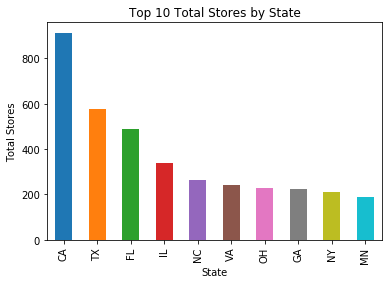

In [10]:
plt.figure(figsize = (11,5) )
df_state.sort_values(by = 'Store ID', ascending = False)[0:10].plot(x = 'State', y= 'Store ID', 
                                                                    kind = 'bar', legend = None)
plt.ylabel('Total Stores')
plt.title('Top 10 Total Stores by State')

## Confounding Variables

__It is vital to watch for confounding variables__ in correlation analysis

# Paired Test Design

## Subjective Way

e.g. Find a best control unit for Store ID 111

In [11]:
df[df['Store ID'] == 111]

,Store ID,City,State,Zip Code,Category Sales,Product Count,Size
110,111,Irvine,CA,92618,9556.14,5,Large


Thinking Process -- we need to find the store:
- That are in the same state
- Are similar in Sales
- Have similar Product Count

__Note__: Size has been ruled out from previous analysis as it does not contribute to Sales

In [12]:
df[df['Store ID'].isin([3498,5035,6108])]

,Store ID,City,State,Zip Code,Category Sales,Product Count,Size
3497,3498,Santa Maria,CA,93455,9532.24,6,Large
5034,5035,Roseville,CA,95661,9602.96,5,Large
6107,6108,West Monroe,LA,71291,9557.29,5,Small


This seems subjective using judgment -- there's a more systematic way to determine this

## Using KD-Tree to find paired tests systematically

In [13]:
df_test = pd.read_csv(treatment)
df_test.head()

,Store ID,City,State,Zip Code,Category Sales,Product Count,Size
0,332,La Mesa,CA,91942,56792.96,5,Large
1,944,Palmdale,CA,93551,41.50,1,Large
2,1181,Lake Elsinore,CA,92532,1514.11,4,Large
3,2696,Redondo Beach,CA,90278,2006.88,4,Large
4,2717,Thousand Oaks,CA,91320,80.04,2,Large


Above is our treatment group, we need to use `Category Sales` and `Product Count` as numeric variables to determine the nearest pair across all stores in __California__.

In [16]:
from sklearn.neighbors import KDTree
df_group = df[df.State == 'CA'][['Category Sales', 'Product Count']]
df_group_treatment = df_test[['Category Sales', 'Product Count']]

tree = KDTree(df_group.values)